In [1]:
from functools import partial

import strongholds
import strongholds.graphing as mplt

import numpy as np

from matplotlib import pyplot as plt, gridspec
import ipywidgets

fixed_rng = np.random.default_rng(0)

To predict where the nearest stronghold to the player will be, we can simply generate many different worlds, find the closest stronghold to each one, and plot a histogram of the results.

In [2]:
N = 1*10**5
stronghold_sets = strongholds.generation_heatmap(N, rng=fixed_rng, concatenate=False)

In [3]:
def get_inputs(player: strongholds.Coordinates):
    """Find closest strongholds to player and return info about them"""

    closest_strongholds = strongholds.closest_stronghold(player, stronghold_sets)
    rings = closest_strongholds.closest_ring()

    distances = closest_strongholds.distance(player)
    angles = closest_strongholds.phi - player.phi

    return closest_strongholds, rings, distances, angles

def histogram_xy(data):
    """creates xy points from histogram of data"""

    hist, bin_edges = np.histogram(data, bins=25)
    hist = hist.astype(float) / N
    bin_centers = strongholds.math.bin_centers(bin_edges)
    hist[hist == 0] = np.nan
    return bin_centers, hist

def xz_histogram(closest_strongholds: strongholds.Coordinates, ax):
    """makes 2d heatmap data of closest_strongholds"""

    return ax.hist2d(closest_strongholds.x,
                     closest_strongholds.z,
                     bins=60, density=True)

def d_theta_histogram(distances, angles, rings):
    """makes 1d histograms of distances and angles"""

    kwargs = []
    for n, color in enumerate(strongholds.graphing.ring_colors):
        mask = rings == n
        label = str(n) if np.count_nonzero(mask) > 0 else None

        d_bins, hist_d = histogram_xy(distances[mask])
        theta_bins, hist_theta = histogram_xy(angles[mask])

        settings_kwargs = {"color": color, "label": label}
        d_args = (d_bins, hist_d, settings_kwargs)
        theta_args = (theta_bins, hist_theta, settings_kwargs)
        kwargs.append((d_args, theta_args))

    return kwargs

interactive(children=(FloatSlider(value=0.0, description='r', max=25000.0, step=1.0), FloatSlider(value=0.0, d…

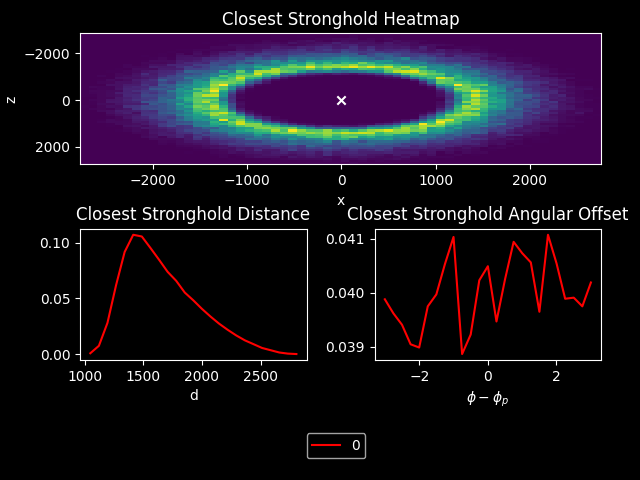

In [4]:
%matplotlib widget

# 2x2 grid
gs = gridspec.GridSpec(2, 2)

fig = plt.figure()
ax = [fig.add_subplot(gs[0, :]),
      fig.add_subplot(gs[1, 0]),
      fig.add_subplot(gs[1, 1])]

fig.tight_layout(pad=2, h_pad=3.5)
fig.subplots_adjust(left=0.125, bottom=0.25)

ax[0].set_title("Closest Stronghold Heatmap")
ax[0].set_xlabel("x")
ax[0].set_ylabel("z")

ax[1].set_title("Closest Stronghold Distance")
ax[1].set_xlabel("d")

ax[2].set_title("Closest Stronghold Angular Offset")
ax[2].set_xlabel("$\\phi - \\phi_p$")

player = strongholds.Coordinates.from_rect(0, 0)
player_point = ax[0].scatter(player.x, player.z, marker="x", zorder=1000, color="white")

closest_strongholds, rings, distances, angles = get_inputs(player)

hist_xz = xz_histogram(closest_strongholds, ax[0])[-1]

hists_d, hists_theta = [], []

for d_args, theta_args in d_theta_histogram(distances, angles, rings):
    hists_d.append(ax[1].plot(*d_args[:2], **d_args[2])[0])
    hists_theta.append(ax[2].plot(*theta_args[:2], **theta_args[2])[0])

# add sliders
r_slider = ipywidgets.FloatSlider(value=0, min=0, max=25000, step=1)
phi_slider = ipywidgets.FloatSlider(value=0, min=-np.pi, max=np.pi, step=0.01)

@ipywidgets.interact(r=r_slider, phi=phi_slider)
def update(r: float, phi: float) -> None:
    global hist_xz

    # get new location
    player = strongholds.Coordinates.from_polar(r, phi)
    player_point.set_offsets(player.to_xz())

    # update inputs
    closest_strongholds, rings, distances, angles = get_inputs(player)

    # redraw xz histogram
    hist_xz.remove()
    hist_xz = xz_histogram(closest_strongholds, ax[0])[-1]

    # update d and theta histograms
    kwargs = d_theta_histogram(distances, angles, rings)
    for n, (d_args, theta_args) in enumerate(kwargs):
        d_plot, theta_plot = hists_d[n], hists_theta[n]
        d_bins, hist_d, d_kwargs = d_args
        theta_bins, hist_theta, theta_kwargs = theta_args

        d_plot.set_data(d_bins, hist_d)
        d_plot.set_label(d_kwargs["label"])

        theta_plot.set_data(theta_bins, hist_theta)
        theta_plot.set_label(theta_kwargs["label"])

    # update view
    for ax_ in ax:
        ax_.relim()
        ax_.autoscale_view()
    mplt.flip_zaxis(ax[0])
    ax[1].legend(loc=(1, -0.75))

As expected, stronghold generation is approximately symmetric in $\phi$, so we can perform future analyses in terms of $r$ only. From there, we find that the closest stronghold is in a small segment of the closest ring that tapers off as the angle deviates, with the contribution from the second closest ring varying with how far it is relative to the first.

Let's analyze the probability that you'll find the closest stronghold in a given ring:

In [6]:
S = strongholds.generation_heatmap(10**3, rng=fixed_rng, concatenate=False)
r_ = np.linspace(0, 30000, 2000)
r = strongholds.Coordinates(r_)

s = strongholds.closest_stronghold(r, S)
i = r.closest_ring()
j = s.closest_ring()

mj, dj = j.mean(axis=-1), j.std(axis=-1)

bin_j = np.apply_along_axis(lambda a: np.histogram(a, bins=8, range=(0, 8), density=True)[0], 1, j)

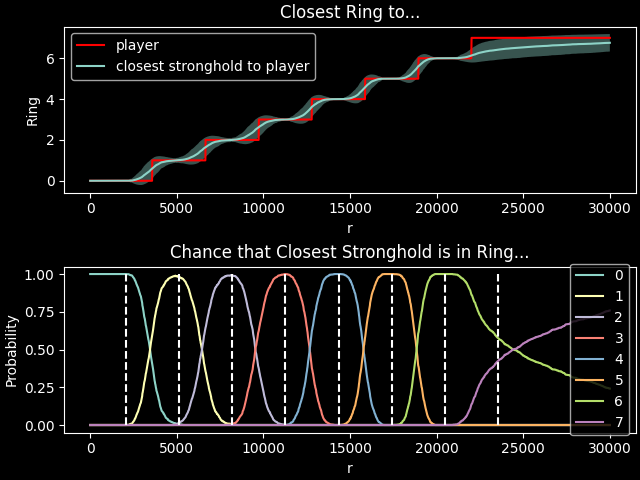

In [7]:
fig2, ax2 = plt.subplots(2, 1, constrained_layout=True)

ax2[0].set_title("Closest Ring to...")
ax2[0].set_xlabel("r")
ax2[0].set_ylabel("Ring")

ax2[1].set_title("Chance that Closest Stronghold is in Ring...")
ax2[1].set_xlabel("r")
ax2[1].set_ylabel("Probability")

p1, = ax2[0].plot(r_, i, color="red", label="player")

p2, = ax2[0].plot(r_, mj, label="closest stronghold to player")
dp2 = ax2[0].fill_between(r_, mj - dj, mj + dj, alpha=0.4)

for k in range(8):
    _ = ax2[1].plot(r_, bin_j[:, k], label=str(k))

_ = ax2[1].vlines(strongholds.chunk_math.ring_centers, 0, 1, linestyles="dashed")

_ = ax2[0].legend()
_ = ax2[1].legend(loc="center right")

Breaking this down, we find that for an intermediate ring $k$, the closer you are radially to the middle of the ring $\bar{r}_k$, the more likely it is that the closest stronghold will be within the same ring. This is also guaranteed for $r \leq \bar{r}_0$ (as that places you on the interior of the 0th ring).

The deviation in end behavior for $k \in \{6, 7\}$ occurs because the rings terminate after $k = 7$; if there were more rings, they would follow a similar generation pattern.